In [ ]:
import os
import sys
import pdb
import torch

print("Is CUDA available? {}".format(torch.cuda.is_available()))

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split

sys.path.insert(0, '..')
## Generating synthetic data
def plot_func(x, y, quantiles=None, quantile_labels=None, max_show=5000,
              shade_color="", method_name="", title="", filename=None, save_figures=False):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    x : numpy array, corresponding to the feature of each of the n samples
    y : numpy array, target response variable (length n)
    quantiles : numpy array, the estimated prediction. It may be the conditional mean,
                or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """
    
    x_ = x[:max_show]
    y_ = y[:max_show]
    if quantiles is not None:
        quantiles = quantiles[:max_show]
    
    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds], y_[inds], 'k.', alpha=.2, markersize=10, fillstyle='none')
    
    if quantiles is not None:
        num_quantiles = quantiles.shape[1]
    else:
        num_quantiles = 0  
    
    if quantile_labels is None:
        pred_labels = ["NA"] * num_quantiles
    for k in range(num_quantiles):
        label_txt = 'Quantile {q}'.format(q=quantile_labels[k])
        plt.plot(x_[inds], quantiles[inds,k], '-', lw=2, alpha=0.75, label=label_txt)
    
    plt.ylim([-2, 20])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.title(title)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()


Text(0.5, 1.0, 'Test data (visualize outliers)')

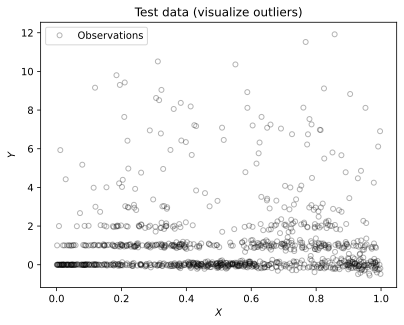

In [109]:

from chr import models
from chr import coverage
import random
def set_random_seed(seed):
    # Python
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    # CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 如果使用多GPU
        # 确定性算法
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    # 设置Python hash种子
    os.environ['PYTHONHASHSEED'] = str(seed)

# 使用方法
set_random_seed(88)

data_model = models.Model_Ex1(symmetry=0) 

# Generate training samples
n_train = 2000
X_data, Y_data = data_model.sample(n_train)
X_train, X_calib, Y_train, Y_calib = train_test_split(X_data, Y_data, test_size=0.5, random_state=88)


# Generate test samples
n_test = 1000
X_test, Y_test = data_model.sample(n_test)

# Plot data
split_color = 'tomato'
local_color = 'gray'
cqr_color = 'lightblue'

# maximal number of testpoints to plot
max_show = 1000

# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(X_test[:,0], Y_test, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data (visualize outliers)')


In [110]:
from chr.black_boxes import QNet, QRF
from chr.black_boxes_r import QBART

# Which quantiles should we estimate?
grid_quantiles = np.arange(0.01,1.0,0.02)

# Which black-box model?
bbox_name = "NNet"

if bbox_name=="NNet":
    bbox = QNet(grid_quantiles, 1, no_crossing=True, batch_size=1000, dropout=0.1,
                num_epochs=10000, learning_rate=0.0005, num_hidden=256, calibrate=0)
elif bbox_name=="RF":
    bbox = QRF(grid_quantiles, n_estimators=100, min_samples_leaf=50, random_state=88)
elif bbox_name=="BART":
    bbox = QBART(grid_quantiles, random_state=88)

loss_stats = bbox.fit(X_train, Y_train)

Training with 1000 samples and 1 features.


In [111]:
# CIR_rank also names CIR+ in the paper
from chr.ours import CIR,CIR_rank
from chr.others import CQR
from chr.methods import CHR
alpha  = 0.1

cir = CIR(bbox, ymin=min(Y_data), ymax=max(Y_data))
cir.calibrate(X_calib, Y_calib, alpha)
cir_bands = cir.predict(X_test)
cir_rank = CIR_rank(bbox, ymin=min(Y_data), ymax=max(Y_data))
cir_rank.calibrate(X_calib, Y_calib, alpha)
cir_rank_bands = cir_rank.predict(X_test)

# Initialize black-box and conformalizer
cqr = CQR(bbox)
# Calibrate the conformalizer
cqr.calibrate(X_calib, Y_calib, alpha)
bands_cqr = cqr.predict(X_test)
# Initialize and calibrate the new method
chr = CHR(bbox, ymin=min(Y_data), ymax=max(Y_data), y_steps=100, delta_alpha=0.001, randomize=True)
chr.calibrate(X_calib, Y_calib, alpha)
bands = chr.predict(X_test)

Calibrated score corrections: -0.011, 0.011


Computing conformity scores.


  0%|          | 0/999 [00:00<?, ?it/s]

Calibrated alpha (nominal level: 0.1): 0.111.


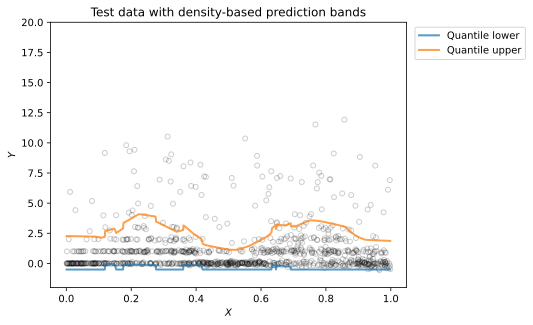

In [112]:
plot_func(X_test[:,0], Y_test, quantiles=cir_bands, quantile_labels=["lower", "upper"], 
          title="Test data with density-based prediction bands")

<Figure size 640x480 with 0 Axes>

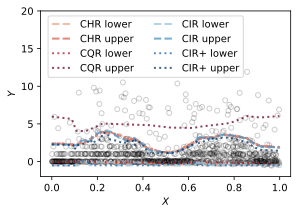

In [113]:
fig = plt.figure()

def make_plots(x, y, limits=None, limit_labels=None, limit_styles=None, max_show=5000, filename=None):
    x_ = x[:max_show]
    y_ = y[:max_show]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds], y_[inds], 'k.', alpha=.2, markersize=10, fillstyle='none')

    if limits is not None:
        num_limits = limits.shape[1]
    else:
        num_limits = 0  
    
    if limit_styles is None:
        limit_styles = ['-'] * num_limits
    
    if limit_labels is None:
        pred_labels = ["NA"] * num_limits
    for k in range(num_limits):
        label_txt = '{q}'.format(q=limit_labels[k])
        plt.plot(x_[inds], limits[inds,k], limit_styles[k], lw=2, alpha =0.75,label=label_txt,color = ['#F4A582', '#D6604D', '#B2182B', '#67001F', '#92C5DE80', '#4393C3', '#2166ACFF', '#053061FF'][k])
    
    plt.ylim([-2, 20])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', ncol=2)
    
    if filename is not None:
        fig.set_size_inches(4.5, 3)
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        
    plt.show()
    
make_plots(X_test[:,0], Y_test, 
           limits=np.concatenate([bands,bands_cqr,cir_bands,cir_rank_bands],1), 
           limit_labels=["CHR lower", "CHR upper","CQR lower", "CQR upper","CIR lower", "CIR upper", "CIR+ lower", "CIR+ upper"],
           limit_styles=['--','--',':',':','--','--',':',':'],
           filename="bands_comparison.png")

In [114]:
from chr.utils import evaluate_predictions
print('bands_chr')
print(evaluate_predictions(bands, Y_test, X=X_test))
print('bands_cqr')
print(evaluate_predictions(bands_cqr, Y_test, X=X_test))
print('cir')
print(evaluate_predictions(cir_bands, Y_test, X=X_test))
print('cir+')
print(evaluate_predictions(cir_rank_bands, Y_test, X=X_test))

bands_chr


   Coverage  Conditional coverage    Length  Length cover
0     0.897              0.918919  2.952928      2.952928
bands_cqr
   Coverage  Conditional coverage    Length  Length cover
0     0.905              0.723404  5.206403      5.206403
cir
   Coverage  Conditional coverage    Length  Length cover
0     0.898              0.918919  2.971774      2.971773
cir+
   Coverage  Conditional coverage    Length  Length cover
0     0.885              0.921053  2.673432      2.673433


-0.23403432272901437


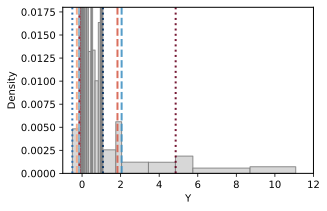

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from chr.grey_boxes import HistogramAccumulator
from chr.histogram import Histogram
from chr.utils import plot_histogram

# Discrete grid for density estimator
grid_histogram =  np.linspace(min(Y_data), max(Y_data), 22)
# Initialize conditional density estimator
hist = Histogram(grid_quantiles, grid_histogram)
# Estimate conditional density for test points
Q_test = bbox.predict(X_test)
histogram_test = hist.compute_histogram(Q_test, min(Y_data),  max(Y_data), 0.1)

i = 1
# def combined_histogram(Q_test, grid_histogram, histogram_test,i_plot):
def combined_histogram(Q_test,i_plot):
    padded_quantiles = np.pad(Q_test, ((0,0),(1, 1)), 'constant', constant_values=(min(Y_data), max(Y_data)))[i_plot]
    m = len(padded_quantiles)-1
    
    # Calculate bar heights
    heights = 1 / ((m) * (padded_quantiles[1:] - padded_quantiles[:-1])*(max(Y_data)-min(Y_data)))
    # Create the plot
    fig, ax = plt.subplots() 
    fig.set_size_inches(4.5, 3)
    # Plot the bars

    widths = padded_quantiles[1:] - padded_quantiles[:-1]
    ax.bar(padded_quantiles[:-1], heights, 
        width=widths,
        align='edge', edgecolor='grey', color='lightgrey', alpha=0.9, 
        label='Interquantile Intervals')

    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    
    colors = ['#F4A582', '#D6604D', '#B2182B', '#67001F', '#92C5DE80', '#4393C3', '#2166ACFF', '#053061FF']
    labels = ["CHR lower", "CHR upper", "CQR lower", "CQR upper", "CIR lower", "CIR upper", "CIR+ lower", "CIR+ upper"]
    limit_styles = ['--','--',':',':','--','--',':',':']


    data = [bands[i_plot][0], bands[i_plot][1], bands_cqr[i_plot][0], bands_cqr[i_plot][1], 
            cir_bands[i_plot][0], cir_bands[i_plot][1], cir_rank_bands[i_plot][0], cir_rank_bands[i_plot][1]]
    print( cir_rank_bands[i_plot][0]- bands[i_plot][0])
    for x, color, label,style in zip(data, colors, labels, limit_styles):
        if (x == bands_cqr[i_plot][0]):
            ax.axvline(x=x,ymin=-0.05,color=color, label=label, linewidth=2, linestyle=style,alpha=0.9)
            
        ax.axvline(x=x, color=color, label=label, linewidth=2, linestyle=style,alpha=0.9)

    ax.set_xlabel('Y')
    ax.set_ylabel('Density')
  
    plt.xlim([-1, 12])
    plt.ylim([0, 0.018])
    plt.savefig("interquantile.png", bbox_inches='tight', dpi=300)
    plt.show()
i_plot = np.where(np.abs(X_test[:,0]-0.4)<0.02)[0][0]

combined_histogram(Q_test,i_plot)